In [1]:
import yfinance as yf

In [263]:
data = yf.download(
    tickers = "TSLA",
    period = "2y",
    interval = "1h",
    ignore_tz = True,
    prepost = False
)

[*********************100%***********************]  1 of 1 completed


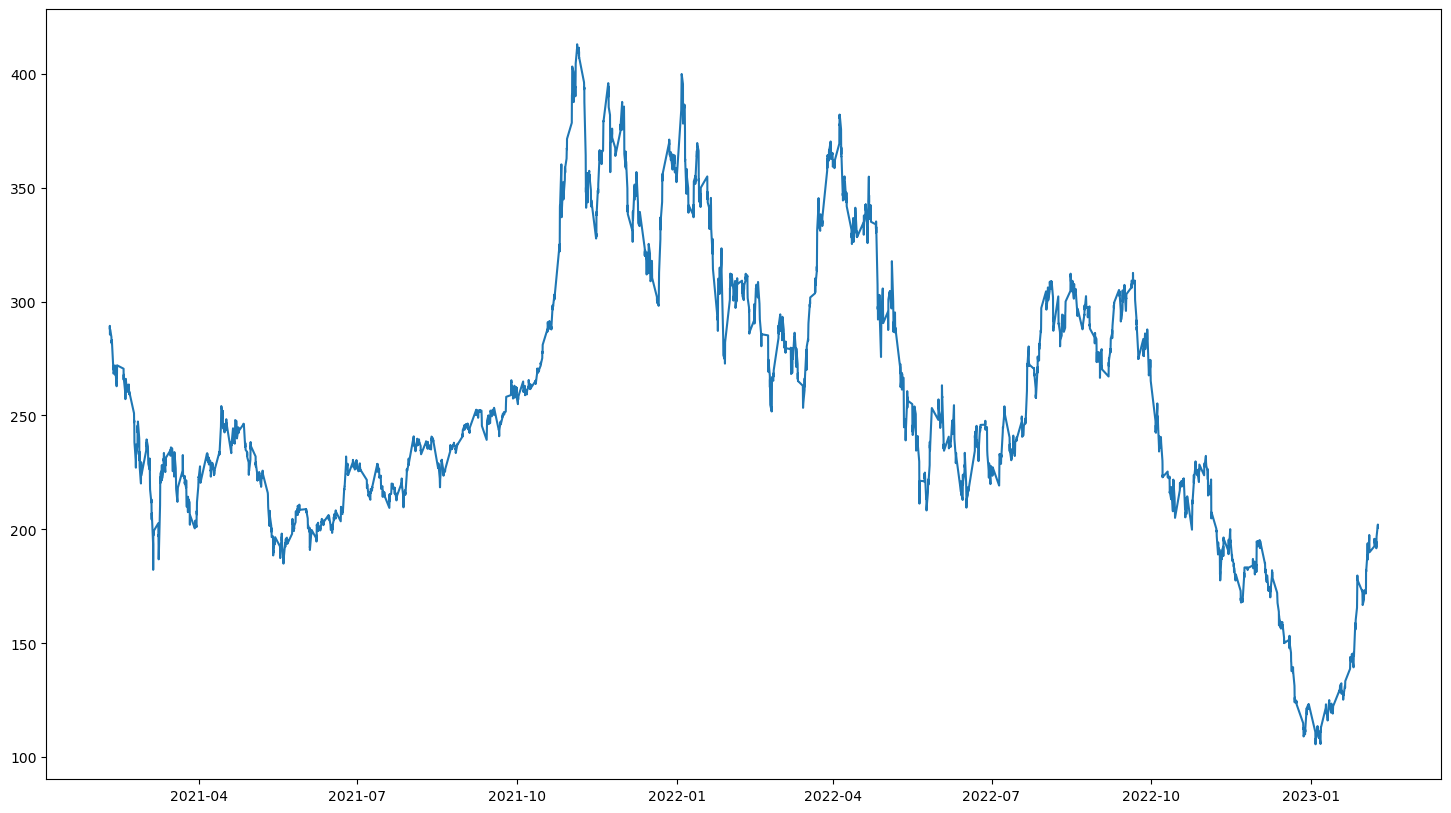

In [311]:
from matplotlib import pyplot as plt

plt.figure(figsize=(18,10))
plt.plot(data['Adj Close'], label='price')

In [359]:
def test_strategy(prices, grad=1.015, btn=2, stop_profit=0.08, stop_loss=0.03, percentage=1.):
    sigs = []
    stock_num = 0
    
    ub = 0
    uflag = False
    db = 0
    dflag = False
    
    for i in range(len(prices)):
        cur_state = 'keep'
        act_flag = False
        price = prices[i]
        
        ma5 = sum(prices[i-5:i]) / 5
        ma20 = sum(prices[i-20:i]) / 20
        
        if ma20 >= ma5:
            uflag = True
        else:
            dflag = True
        
        if uflag and ma5 > ma20 and ma5 - ma20 > grad:
            ub += 1
            
        if dflag and ma20 > ma5 and ma20 - ma5 > grad:
            db += 1
            
        if ub >= btn:
            cur_state = 'buy'
            ub = 0
            uflag = False
            db = 0
            dflag = False
            act_flag = True
            
        if db >= btn:
            cur_state = 'sell'
            ub = 0
            uflag = False
            db = 0
            dflag = False
            act_flag = True
            
        if not act_flag and stock_num > 0:
            if prices[i] > prices[i-1]:
                if prices[i] / prices[i-1] >= stop_profit:
                    cur_state = 'sell'
                else:
                    cur_state = 'keep'
            else:
                if stop_loss > prices[i-1] / prices[i]:
                    cur_state = 'keep'
                else:
                    cur_state = 'sell'
                        
        if cur_state == 'buy':
            #budget -= prices[i] * num
            #stock_num += num
            sigs.append(('buy', percentage))
            
        elif cur_state == 'sell':
            #budget += prices[i] * stock_num
            sigs.append(('sell', percentage))
            stock_num = 0
        else:
            sigs.append(('keep', 0))
            
    return sigs

In [360]:
def hongMinStrategy(prices, interval=1, stop_loss=0.03, stop_profit=0.08, percentage = 1.):
    stop_loss *= 100
    stop_profit *= 100
    
    totalList = []
    is_buy_signal = False
    minPrice = None
    
    for i in range(len(prices)):
        if minPrice is None:
            minPrice = prices[i]

        grad = i-interval >= 0 and (prices[i] - prices[i-interval]) / interval
        if grad != 0:
            if grad > 0:
                is_buy_signal = True
                minPrice = None
            else:
                is_buy_signal = False

            if minPrice:
                minPrice = prices[i]

        if is_buy_signal:
            totalList.append(("buy", percentage))

        elif int((prices[i] - prices[i-1])/prices[i-1]*100) <= -stop_loss or int((prices[i] - prices[i-1])/prices[i-1]*100) >= stop_profit:
            totalList.append(("sell", percentage))

        else:
            totalList.append(("keep", 0))
            
    return totalList

In [388]:
class BackTesting:
    strategies = set()
    
    def __init__(self, prices, budget=10000):
        self.init_budget = budget
        self.prices = prices
        self.budget = budget
    
    def add_strategy(self, strategy):
        self.strategies.add(strategy)
        
    def test(self, last_sale=True, percentage=1., verbose=False, **kwargs):
        ss = []
        ps = []
        for strategy in self.strategies:
            sigs = strategy(self.prices, percentage=percentage, **kwargs)
            cur_stock_num = 0
            last_budget = 0.
            last_cur_stock_num = 0
            for price, (sig, rate) in zip(self.prices, sigs):
                if self.budget > price and sig == 'buy':
                    num = self.get_stock_num(price, rate)
                    cur_stock_num += num
                    self.budget -= num * price
                elif cur_stock_num > 0 and sig == 'sell':
                    num = int(cur_stock_num * 0.8)
                    self.budget += price * num
                    last_budget = self.budget
                    cur_stock_num -= num
                    last_cur_stock_num = cur_stock_num
                    
                if verbose:
                    print(f'act: {sig} current stock num: {cur_stock_num} total budget: {self.budget + cur_stock_num * price} budget: {self.budget}')
                    
            if last_sale:
                self.budget = last_budget + last_cur_stock_num * price
            else:
                self.budget = self.budget + cur_stock_num * price
            
            print(f'strategy: {strategy.__name__}\t\tprofit: {self.calc_profit(self.init_budget, self.budget)}')
            print(f'before: {self.init_budget} / after: {self.budget}')
            print('='*80)
            ss.append(strategy.__name__)
            ps.append(self.calc_profit(self.init_budget, self.budget))
            self.reset()
        return ss, ps
            
    def reset(self):
        self.budget = self.init_budget
        
    def get_stock_num(self, price, rate):
        return int(int(self.budget / price) * rate)
        
    def calc_profit(self, before, after):
        return ((after/before) - 1)* 100
        

In [389]:
tester = BackTesting(data['Adj Close'])

In [390]:
tester.add_strategy(test_strategy)
tester.add_strategy(hongMinStrategy)

In [391]:
tester.test(percentage=0.2)

strategy: test_strategy		profit: 0.22034378051758452
before: 10000 / after: 10022.034378051758
strategy: hongMinStrategy		profit: -30.662586135864256
before: 10000 / after: 6933.741386413574


(['test_strategy', 'hongMinStrategy'],
 [0.22034378051758452, -30.662586135864256])

In [392]:
tester.test(percentage=0.5)

strategy: test_strategy		profit: -13.661247024536127
before: 10000 / after: 8633.875297546387
strategy: hongMinStrategy		profit: -34.987195892333986
before: 10000 / after: 6501.280410766602


(['test_strategy', 'hongMinStrategy'],
 [-13.661247024536127, -34.987195892333986])

In [393]:
tester.test(percentage=0.8)

strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: -33.87746971130371
before: 10000 / after: 6612.253028869629


(['test_strategy', 'hongMinStrategy'],
 [-28.944766006469724, -33.87746971130371])

In [387]:
tester.test(percentage=1.0, stop_loss=0.005)

strategy: test_strategy		profit: -44.07159156799316
before: 10000 / after: 5592.840843200684
strategy: hongMinStrategy		profit: 90.98524627685546
before: 10000 / after: 19098.524627685547


(['test_strategy', 'hongMinStrategy'], [-44.07159156799316, 90.98524627685546])

In [366]:
tester.test(percentage=0.1)

strategy: test_strategy		profit: -0.8631707763671836
before: 10000 / after: 9913.682922363281
strategy: hongMinStrategy		profit: -14.612489242553705
before: 10000 / after: 8538.751075744629


(['test_strategy', 'hongMinStrategy'],
 [-0.8631707763671836, -14.612489242553705])

In [382]:
from matplotlib import pyplot as plt
from tqdm import tqdm

results = []

for i in tqdm(range(1, 51)):
    i /= 1000
    
    ss, ps = tester.test(percentage=0.8, stop_loss=i)
    results.append((ss, ps))

  2%|██▎                                                                                                               | 1/50 [00:00<00:09,  4.92it/s]

strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: 61.22019523620605
before: 10000 / after: 16122.019523620605
strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: 61.22019523620605
before: 10000 / after: 16122.019523620605


  6%|██████▊                                                                                                           | 3/50 [00:00<00:08,  5.32it/s]

strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: 61.22019523620605
before: 10000 / after: 16122.019523620605
strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: 61.22019523620605
before: 10000 / after: 16122.019523620605


 12%|█████████████▋                                                                                                    | 6/50 [00:01<00:08,  5.45it/s]

strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: 61.22019523620605
before: 10000 / after: 16122.019523620605
strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: 61.22019523620605
before: 10000 / after: 16122.019523620605


 14%|███████████████▉                                                                                                  | 7/50 [00:01<00:07,  5.44it/s]

strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: 61.22019523620605
before: 10000 / after: 16122.019523620605
strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: 61.22019523620605
before: 10000 / after: 16122.019523620605


 18%|████████████████████▌                                                                                             | 9/50 [00:01<00:07,  5.43it/s]

strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: 61.22019523620605
before: 10000 / after: 16122.019523620605
strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: 61.22019523620605
before: 10000 / after: 16122.019523620605


 22%|████████████████████████▊                                                                                        | 11/50 [00:02<00:07,  5.41it/s]

strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: 23.47913818359375
before: 10000 / after: 12347.913818359375
strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: 23.47913818359375
before: 10000 / after: 12347.913818359375


 26%|█████████████████████████████▍                                                                                   | 13/50 [00:02<00:06,  5.41it/s]

strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: 23.47913818359375
before: 10000 / after: 12347.913818359375
strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: 23.47913818359375
before: 10000 / after: 12347.913818359375


 30%|█████████████████████████████████▉                                                                               | 15/50 [00:02<00:06,  5.36it/s]

strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: 23.47913818359375
before: 10000 / after: 12347.913818359375
strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027


 34%|██████████████████████████████████████▍                                                                          | 17/50 [00:03<00:06,  5.33it/s]

strategy: hongMinStrategy		profit: 23.47913818359375
before: 10000 / after: 12347.913818359375
strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: 23.47913818359375
before: 10000 / after: 12347.913818359375


 36%|████████████████████████████████████████▋                                                                        | 18/50 [00:03<00:05,  5.35it/s]

strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: 23.47913818359375
before: 10000 / after: 12347.913818359375
strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: 23.47913818359375
before: 10000 / after: 12347.913818359375


 40%|█████████████████████████████████████████████▏                                                                   | 20/50 [00:03<00:05,  5.40it/s]

strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: 23.47913818359375
before: 10000 / after: 12347.913818359375
strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: -33.87746971130371
before: 10000 / after: 6612.253028869629


 44%|█████████████████████████████████████████████████▋                                                               | 22/50 [00:04<00:05,  5.43it/s]

strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: -33.87746971130371
before: 10000 / after: 6612.253028869629
strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: -33.87746971130371
before: 10000 / after: 6612.253028869629


 48%|██████████████████████████████████████████████████████▏                                                          | 24/50 [00:04<00:04,  5.43it/s]

strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: -33.87746971130371
before: 10000 / after: 6612.253028869629
strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: -33.87746971130371
before: 10000 / after: 6612.253028869629


 52%|██████████████████████████████████████████████████████████▊                                                      | 26/50 [00:04<00:04,  5.42it/s]

strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: -33.87746971130371
before: 10000 / after: 6612.253028869629
strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: -33.87746971130371
before: 10000 / after: 6612.253028869629


 56%|███████████████████████████████████████████████████████████████▎                                                 | 28/50 [00:05<00:04,  5.35it/s]

strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: -33.87746971130371
before: 10000 / after: 6612.253028869629
strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027


 60%|███████████████████████████████████████████████████████████████████▊                                             | 30/50 [00:05<00:03,  5.35it/s]

strategy: hongMinStrategy		profit: -33.87746971130371
before: 10000 / after: 6612.253028869629
strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: -33.87746971130371
before: 10000 / after: 6612.253028869629


 62%|██████████████████████████████████████████████████████████████████████                                           | 31/50 [00:05<00:03,  5.36it/s]

strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: -52.005294494628906
before: 10000 / after: 4799.470550537109
strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: -52.005294494628906
before: 10000 / after: 4799.470550537109


 66%|██████████████████████████████████████████████████████████████████████████▌                                      | 33/50 [00:06<00:03,  5.39it/s]

strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: -52.005294494628906
before: 10000 / after: 4799.470550537109
strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: -52.005294494628906
before: 10000 / after: 4799.470550537109


 70%|███████████████████████████████████████████████████████████████████████████████                                  | 35/50 [00:06<00:02,  5.40it/s]

strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: -52.005294494628906
before: 10000 / after: 4799.470550537109
strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: -52.005294494628906
before: 10000 / after: 4799.470550537109


 74%|███████████████████████████████████████████████████████████████████████████████████▌                             | 37/50 [00:06<00:02,  5.40it/s]

strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: -52.005294494628906
before: 10000 / after: 4799.470550537109
strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: -52.005294494628906
before: 10000 / after: 4799.470550537109


 78%|████████████████████████████████████████████████████████████████████████████████████████▏                        | 39/50 [00:07<00:02,  5.40it/s]

strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: -52.005294494628906
before: 10000 / after: 4799.470550537109
strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: -52.005294494628906
before: 10000 / after: 4799.470550537109


 82%|████████████████████████████████████████████████████████████████████████████████████████████▋                    | 41/50 [00:07<00:01,  5.40it/s]

strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: -49.20109466552734
before: 10000 / after: 5079.890533447266
strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: -49.20109466552734
before: 10000 / after: 5079.890533447266


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▏               | 43/50 [00:07<00:01,  5.41it/s]

strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: -49.20109466552734
before: 10000 / after: 5079.890533447266
strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: -49.20109466552734
before: 10000 / after: 5079.890533447266


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 45/50 [00:08<00:00,  5.40it/s]

strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: -49.20109466552734
before: 10000 / after: 5079.890533447266
strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: -49.20109466552734
before: 10000 / after: 5079.890533447266


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 47/50 [00:08<00:00,  5.39it/s]

strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: -49.20109466552734
before: 10000 / after: 5079.890533447266
strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: -49.20109466552734
before: 10000 / after: 5079.890533447266


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 49/50 [00:09<00:00,  5.40it/s]

strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: -49.20109466552734
before: 10000 / after: 5079.890533447266
strategy: test_strategy		profit: -28.944766006469724
before: 10000 / after: 7105.523399353027
strategy: hongMinStrategy		profit: -49.20109466552734
before: 10000 / after: 5079.890533447266


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.40it/s]


In [383]:
results

[(['test_strategy', 'hongMinStrategy'],
  [-28.944766006469724, 61.22019523620605]),
 (['test_strategy', 'hongMinStrategy'],
  [-28.944766006469724, 61.22019523620605]),
 (['test_strategy', 'hongMinStrategy'],
  [-28.944766006469724, 61.22019523620605]),
 (['test_strategy', 'hongMinStrategy'],
  [-28.944766006469724, 61.22019523620605]),
 (['test_strategy', 'hongMinStrategy'],
  [-28.944766006469724, 61.22019523620605]),
 (['test_strategy', 'hongMinStrategy'],
  [-28.944766006469724, 61.22019523620605]),
 (['test_strategy', 'hongMinStrategy'],
  [-28.944766006469724, 61.22019523620605]),
 (['test_strategy', 'hongMinStrategy'],
  [-28.944766006469724, 61.22019523620605]),
 (['test_strategy', 'hongMinStrategy'],
  [-28.944766006469724, 61.22019523620605]),
 (['test_strategy', 'hongMinStrategy'],
  [-28.944766006469724, 61.22019523620605]),
 (['test_strategy', 'hongMinStrategy'],
  [-28.944766006469724, 23.47913818359375]),
 (['test_strategy', 'hongMinStrategy'],
  [-28.944766006469724, 2

In [369]:
v = {
    
}

for s in set(results[0][0]):
    v[s] = {
        'max_p': 0.,
        'max_i': -1
    }
    

for i, (ss, ps) in enumerate(results):
    for j, s in enumerate(ss):
        if ps[j] > v[s]['max_p']:
            v[s]['max_p'] = ps[j]
            v[s]['max_i'] = i
        

In [370]:
for i, s in enumerate(results[0][0]):
    ti = results[v[s]['max_i']][0].index(s)
    print(s, results[v[s]['max_i']][1][ti])

test_strategy -6.532641372680659
hongMinStrategy 4.61274322509766


In [371]:
v = {
    
}

for s in set(results[0][0]):
    v[s] = {
        'min_p': 0.,
        'min_i': -1
    }
    

for i, (ss, ps) in enumerate(results):
    for j, s in enumerate(ss):
        if v[s]['min_p'] > ps[j]:
            v[s]['min_p'] = ps[j]
            v[s]['min_i'] = i
        

In [372]:
for i, s in enumerate(results[0][0]):
    ti = results[v[s]['min_i']][0].index(s)
    print(s, results[v[s]['min_i']][1][ti])

test_strategy -6.532641372680659
hongMinStrategy -100.0
